# 2.3.4 Challenge: Iterate and Evaluate Your Classifier

In [246]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

import re

import seaborn as sns
import matplotlib.pyplot as plt

In [247]:
df = pd.read_csv("imdb_labelled.txt",delimiter='\t',header=None)
df.columns = ['message','positive']
df['positive'] = (df['positive'] == 1)

In [248]:
df.head()

,message,positive
0,"A very, very, very slow-moving, aimless movie ...",False
1,Not sure who was more lost - the flat characte...,False
2,Attempting artiness with black & white and cle...,False
3,Very little music or anything to speak of.,False
4,The best scene in the movie was when Gerardo i...,True


In [249]:
X_train, X_test, y_train, y_test = train_test_split(df['message'].values, 
                 df['positive'].values,        
                 test_size=0.2,
                random_state=0)

In [250]:
df['tokenized_text'] = df['message'].apply(word_tokenize)

In [251]:
vect = CountVectorizer()
tf_train = vect.fit_transform(X_train)
tf_test = vect.transform(X_test)

In [252]:
p = tf_train[y_train==1].sum(0) + 1
q = tf_train[y_train==0].sum(0) + 1
r = np.log((p/p.sum()) / (q/q.sum()))
b = np.log(len(p) / len(q))

### Original Model A

In [253]:
baseline = list(df.positive).count(True)/len(df.positive)
baseline

0.516042780748663

In [254]:
pre_preds = tf_test @ r.T + b
preds = pre_preds.T > 0
accuracy = (preds == y_test).mean()
accuracy

0.8066666666666666

In [255]:
preds = preds.A1
confusion_matrix(preds, y_test)

array([[75, 20],
       [ 9, 46]], dtype=int64)

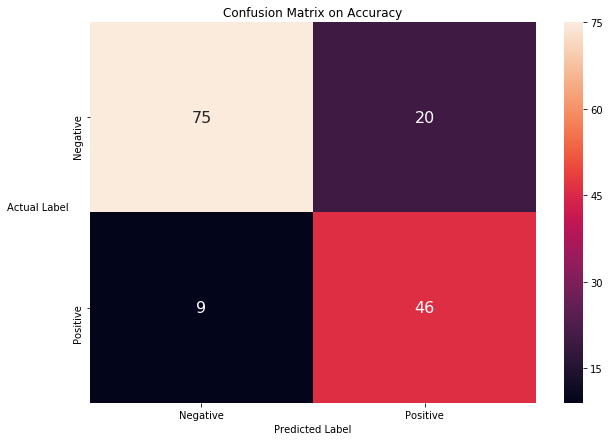

In [256]:
df_cm = pd.DataFrame(confusion_matrix(preds, y_test))

plt.figure(figsize = (10,7))

ax = plt.axes()
sns.heatmap(df_cm, 
            ax = ax,
            annot=True,
            yticklabels=['Negative','Positive'],
            xticklabels=['Negative','Positive'],
            annot_kws={"size": 16})# font size

ax.set_title('Confusion Matrix on Accuracy')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label', rotation='horizontal',horizontalalignment='right')
plt.show()

### Original Model B

In [257]:
model = LogisticRegression(C=0.2, dual=True)
model.fit(tf_train, y_train)
preds = model.predict(tf_test)
accuracy = (preds == y_test).mean()
accuracy

c:\users\paulb\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\paulb\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.7

In [258]:
confusion_matrix(preds, y_test)

array([[47,  8],
       [37, 58]], dtype=int64)

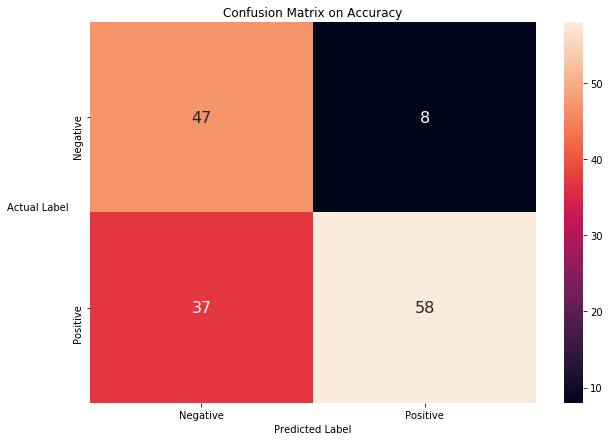

In [259]:
df_cm = pd.DataFrame(confusion_matrix(preds, y_test))

plt.figure(figsize = (10,7))

ax = plt.axes()
sns.heatmap(df_cm, 
            ax = ax,
            annot=True,
            yticklabels=['Negative','Positive'],
            xticklabels=['Negative','Positive'],
            annot_kws={"size": 16})# font size

ax.set_title('Confusion Matrix on Accuracy')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label', rotation='horizontal',horizontalalignment='right')
plt.show()

In [260]:
vocab = vect.get_feature_names()
coef_df = pd.DataFrame({'vocab': vocab, 'coef':model.coef_.reshape(-1)})
pos_top10 = coef_df.sort_values('coef', ascending=False).reset_index(drop=True)[:10]
neg_top10 = coef_df.sort_values('coef').reset_index(drop=True)[:10]

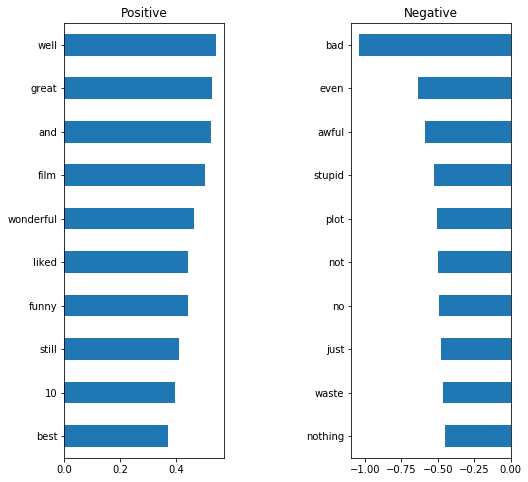

In [261]:
fig, axs = plt.subplots(1, 2, figsize=(8, 8))
fig.subplots_adjust(wspace=0.8)
pos_top10.sort_values('coef').plot.barh(legend=False, ax=axs[0])
axs[0].set_yticklabels(pos_top10['vocab'].values.tolist()[::-1])
axs[0].set_title('Positive');
neg_top10.sort_values('coef', ascending=False).plot.barh(legend=False, ax=axs[1])
axs[1].set_yticklabels(neg_top10['vocab'].values.tolist()[::-1])
axs[1].set_title('Negative');

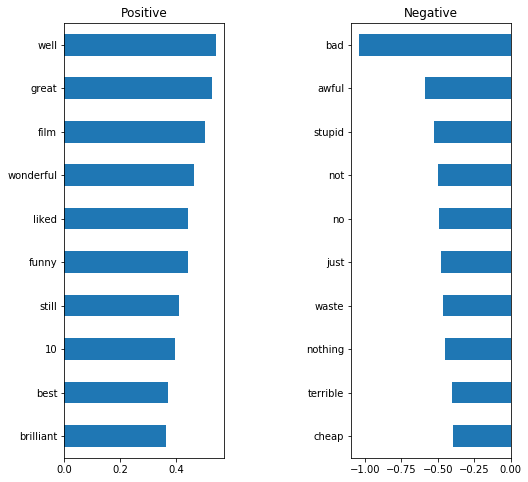

In [262]:
vocab = vect.get_feature_names()
coef_df = pd.DataFrame({'vocab': vocab, 'coef':model.coef_.reshape(-1)})
coef_df = coef_df.drop([107, 51]) # dropping 'and' and 'actually'
coef_df = coef_df.drop([763, 1705, 1594, 83, 327, 2587]) # dropping 'even' and 'plot' and 'only' and 'all' and 'can' and 'would'

pos_top10 = coef_df.sort_values('coef', ascending=False).reset_index(drop=True)[:10]
neg_top10 = coef_df.sort_values('coef').reset_index(drop=True)[:10]

fig, axs = plt.subplots(1, 2, figsize=(8, 8))
fig.subplots_adjust(wspace=0.8)
pos_top10.sort_values('coef').plot.barh(legend=False, ax=axs[0])
axs[0].set_yticklabels(pos_top10['vocab'].values.tolist()[::-1])
axs[0].set_title('Positive');
neg_top10.sort_values('coef', ascending=False).plot.barh(legend=False, ax=axs[1])
axs[1].set_yticklabels(neg_top10['vocab'].values.tolist()[::-1])
axs[1].set_title('Negative');

### Model C: Thinkful Method

In [263]:
positive = coef_df.sort_values('coef', ascending=False).reset_index(drop=True)[:50]

In [264]:
positive_keywords = list(positive.vocab)

for key in positive_keywords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    df[str(key)] = df.message.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

In [265]:
df['positive'] = (df['positive'] == True)

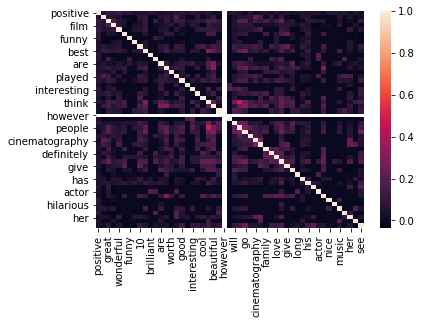

In [266]:
sns.heatmap(df.corr())

In [267]:
data = df[positive_keywords]
target = df['positive']

In [268]:
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(data, target)

y_pred = bnb.predict(data)

print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 748 points : 235


In [269]:
(y_pred == target).mean()

0.6858288770053476

In [270]:
confusion_matrix(target, y_pred)

array([[308,  54],
       [181, 205]], dtype=int64)

In [271]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

With 20% Holdout: 0.62
Testing on Sample: 0.6858288770053476


In [272]:
cross_val_score(bnb, data, target, cv=10)

array([0.59210526, 0.59210526, 0.65333333, 0.65333333, 0.72      ,
       0.6       , 0.7027027 , 0.64864865, 0.64864865, 0.58108108])

### Model D: Thinkful Method (with negative features)

In [273]:
negative = coef_df.sort_values('coef').reset_index(drop=True)[:30]
negative = negative.drop([10,13,14,18,21,23,27]) #dropping non-subjective words

In [274]:
negative_keywords = list(negative.vocab)

for key in negative_keywords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    df[str(key)] = df.message.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

In [283]:
data = df[positive_keywords + negative_keywords]
target = df['positive']

In [285]:
bnb = BernoulliNB()
bnb.fit(data, target)

y_pred = bnb.predict(data)

print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 748 points : 208


In [287]:
(y_pred == target).mean()

0.7219251336898396

In [288]:
confusion_matrix(target, y_pred)

array([[295,  67],
       [141, 245]], dtype=int64)

In [289]:
cross_val_score(bnb, data, target, cv=10)

array([0.63157895, 0.71052632, 0.73333333, 0.69333333, 0.74666667,
       0.64      , 0.78378378, 0.62162162, 0.66216216, 0.7027027 ])

### Model E: Thinkful Method (with negative features plus train test split)

In [295]:
data = df[positive_keywords + negative_keywords]
target = df['positive']

In [296]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

With 20% Holdout: 0.6733333333333333
Testing on Sample: 0.7219251336898396


In [297]:
bnb.fit(X_train,y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

## Interpreting the Results

1. Do any of your classifiers seem to overfit?

No. The model accuracy results were: A at 81%, B at 70%, C at 69%, D at 72%, and E at 72% with the data set being well balanced with a baseline of 51%. 

2. Which seem to perform the best?

Model A performed the best because unlike the subsequent models, it used each word as a feature (meaning there were hundreds of features) instead of being limited to a range of positive or negative words like Model D. 

3. Which features seemed to be most impactiful to performance?

As seen in the bar chart counting the most influential positive and negative words, the presence of the top 10 positive words was very impactful in correctly identifying which reviews were positive. The negative words were a little less so.